In [7]:
import pandas as pd

df_posts = pd.read_sql_query(
    '''
SELECT sp.content, p.author, p.author_title, p.author_location, p.post_date
 FROM subposts sp LEFT JOIN posts p ON sp.post_id=p.post_id
 ''',
    'sqlite:////home/sam/data/stormfront/stormfront.sqlite'
)

In [45]:
import spacy

nlp = spacy.load('en')

In [82]:
import sys

IGNORED_ENTITY_TYPES = {"DATE", "TIME", "PERCENT", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL"}
entities = []
for i, post in enumerate(df_posts.content.fillna('')):
    if i % 10000 == 0:
        print('.', end='')
        sys.stdout.flush()

    doc = nlp(post)
    for ent in doc.ents:
        if ent.label_ in IGNORED_ENTITY_TYPES:
            continue
            
        entities.append((i, ent.text.upper(), ent.label_))
    
    del doc

.......................................................................................................

In [86]:
df_entities = pd.DataFrame(entities, columns=['post_index', 'entity', 'label'])

In [102]:
df_posts.head()

,content,author,author_title,author_location,post_date
0,\nhttp://www.reuters.com/article/oddly...2&pag...,salvete amici,Forum Member,"Christian, Free-market Libertarian",2007-05-24 15:19:00.000000
1,I suppose they wouldn't go down well with a d...,Royal Blue,Forum Member,None,2007-05-24 15:27:00.000000
2,The blacks or the rats? confused.gif \n,ArcticThunder,Account Inactive,U.S.A.,2007-05-24 15:52:00.000000
3,OMG I'll have nightmares for weeks now...YUCK...,BeautynBrains1488,Forum Member,Texico Amexica Where Wetbacks Rule,2007-05-24 16:13:00.000000
4,\r\n\t\t\t\r\n\t\t\tAre you talking about actu...,LOKI-Nevada,Account Disabled by Request,Fled to Utah,2007-05-24 16:16:00.000000


In [105]:
df_entities_with_dates = pd.merge(df_entities, df_posts[['post_date']], left_on='post_index', right_index=True, copy=False)

In [107]:
df_entities_with_dates.sort_values('post_date', inplace=True)

In [189]:
df_entities[df_entities.label == 'NORP'].entity.value_counts()

JEWS                          62495
JEWISH                        45082
AMERICAN                      28952
AMERICANS                     17628
EUROPEAN                      14043
MUSLIMS                       12944
GERMAN                        10814
MUSLIM                        10653
WHITE                         10651
ISRAELI                       10102
RUSSIAN                        9708
JEW                            8889
BRITISH                        8279
CHRISTIAN                      7424
AFRICAN                        6835
CHINESE                        6749
ZIONIST                        5939
MEXICAN                        5781
REPUBLICAN                     5676
FRENCH                         5495
GERMANS                        5366
MEXICANS                       5348
CHRISTIANS                     5315
EUROPEANS                      5247
RUSSIANS                       4498
ASIAN                          4430
DEMOCRATS                      4076
REPUBLICANS                 

In [146]:
posts_by_year = df_posts.groupby(by=pd.DatetimeIndex(df_posts.post_date).year).content.count()

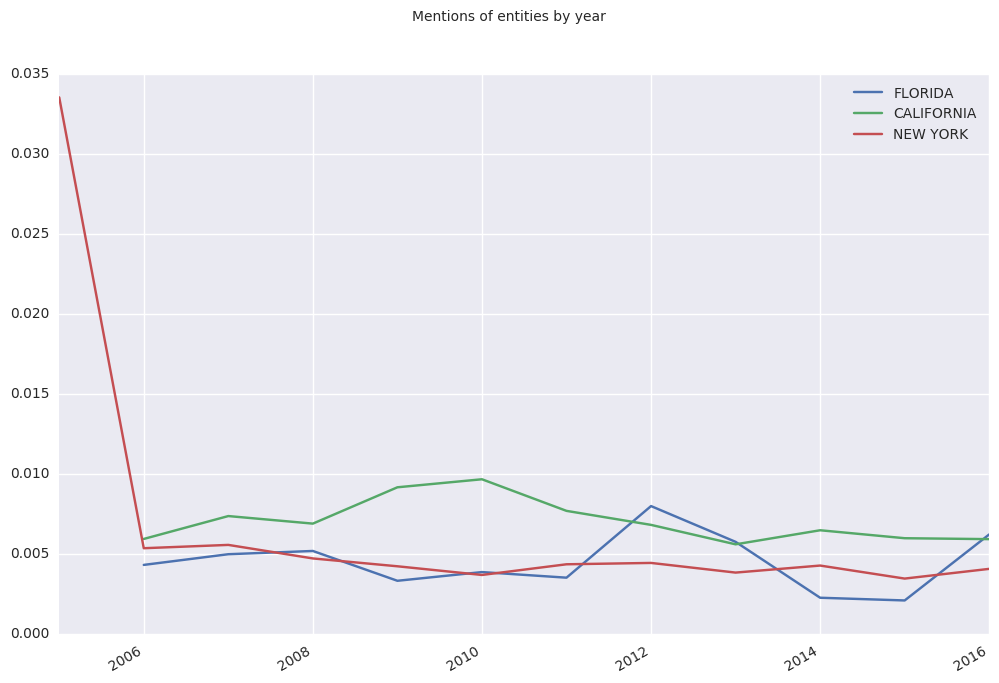

In [186]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 8))

def entity_mentions_by_year(df, entity, normalized=True):
    filtered = df[df.entity == entity]
    date_index = pd.DatetimeIndex(filtered.post_date)
    
    counts = filtered.groupby(by=[date_index.year]).entity.count()
    if normalized:
        counts /= posts_by_year
    
    return counts

def plot_entity_mentions_by_year(df, entity):
    df = entity_mentions_by_year(df, entity)
    if len(df[4:]) == 0:
        return
    
    df[4:].plot(label=entity)
    fig.autofmt_xdate()
    plt.legend()
    plt.suptitle('Mentions of entities by year')


plot_entity_mentions_by_year(df_entities_with_dates, 'FLORIDA')
plot_entity_mentions_by_year(df_entities_with_dates, 'CALIFORNIA')
plot_entity_mentions_by_year(df_entities_with_dates, 'NEW YORK')

In [132]:
df_entities.entity.value_counts()[states].sort_values(ascending=False)

CALIFORNIA              7359.0
TEXAS                   5779.0
WASHINGTON              4831.0
FLORIDA                 4680.0
NEW YORK                4414.0
GEORGIA                 3222.0
ARIZONA                 3003.0
IOWA                    2007.0
OHIO                    1749.0
MONTANA                 1647.0
MICHIGAN                1597.0
OREGON                  1262.0
VIRGINIA                1218.0
LOUISIANA               1180.0
SOUTH CAROLINA          1172.0
COLORADO                1102.0
NEW JERSEY              1084.0
ILLINOIS                1058.0
PENNSYLVANIA            1040.0
MISSOURI                1022.0
NEW HAMPSHIRE           1003.0
ALABAMA                  998.0
MINNESOTA                995.0
HAWAII                   902.0
MISSISSIPPI              900.0
TENNESSEE                896.0
UTAH                     855.0
WISCONSIN                846.0
INDIANA                  829.0
NEVADA                   795.0
ALASKA                   788.0
NORTH CAROLINA           785.0
IDAHO   

In [156]:
state_mentions_by_year = {}
for state in states:
    state_mentions_by_year[state] = entity_mentions_by_year(df_entities_with_dates, state)

In [157]:
df_state_mentions_by_year = pd.DataFrame(state_mentions_by_year).fillna(0)

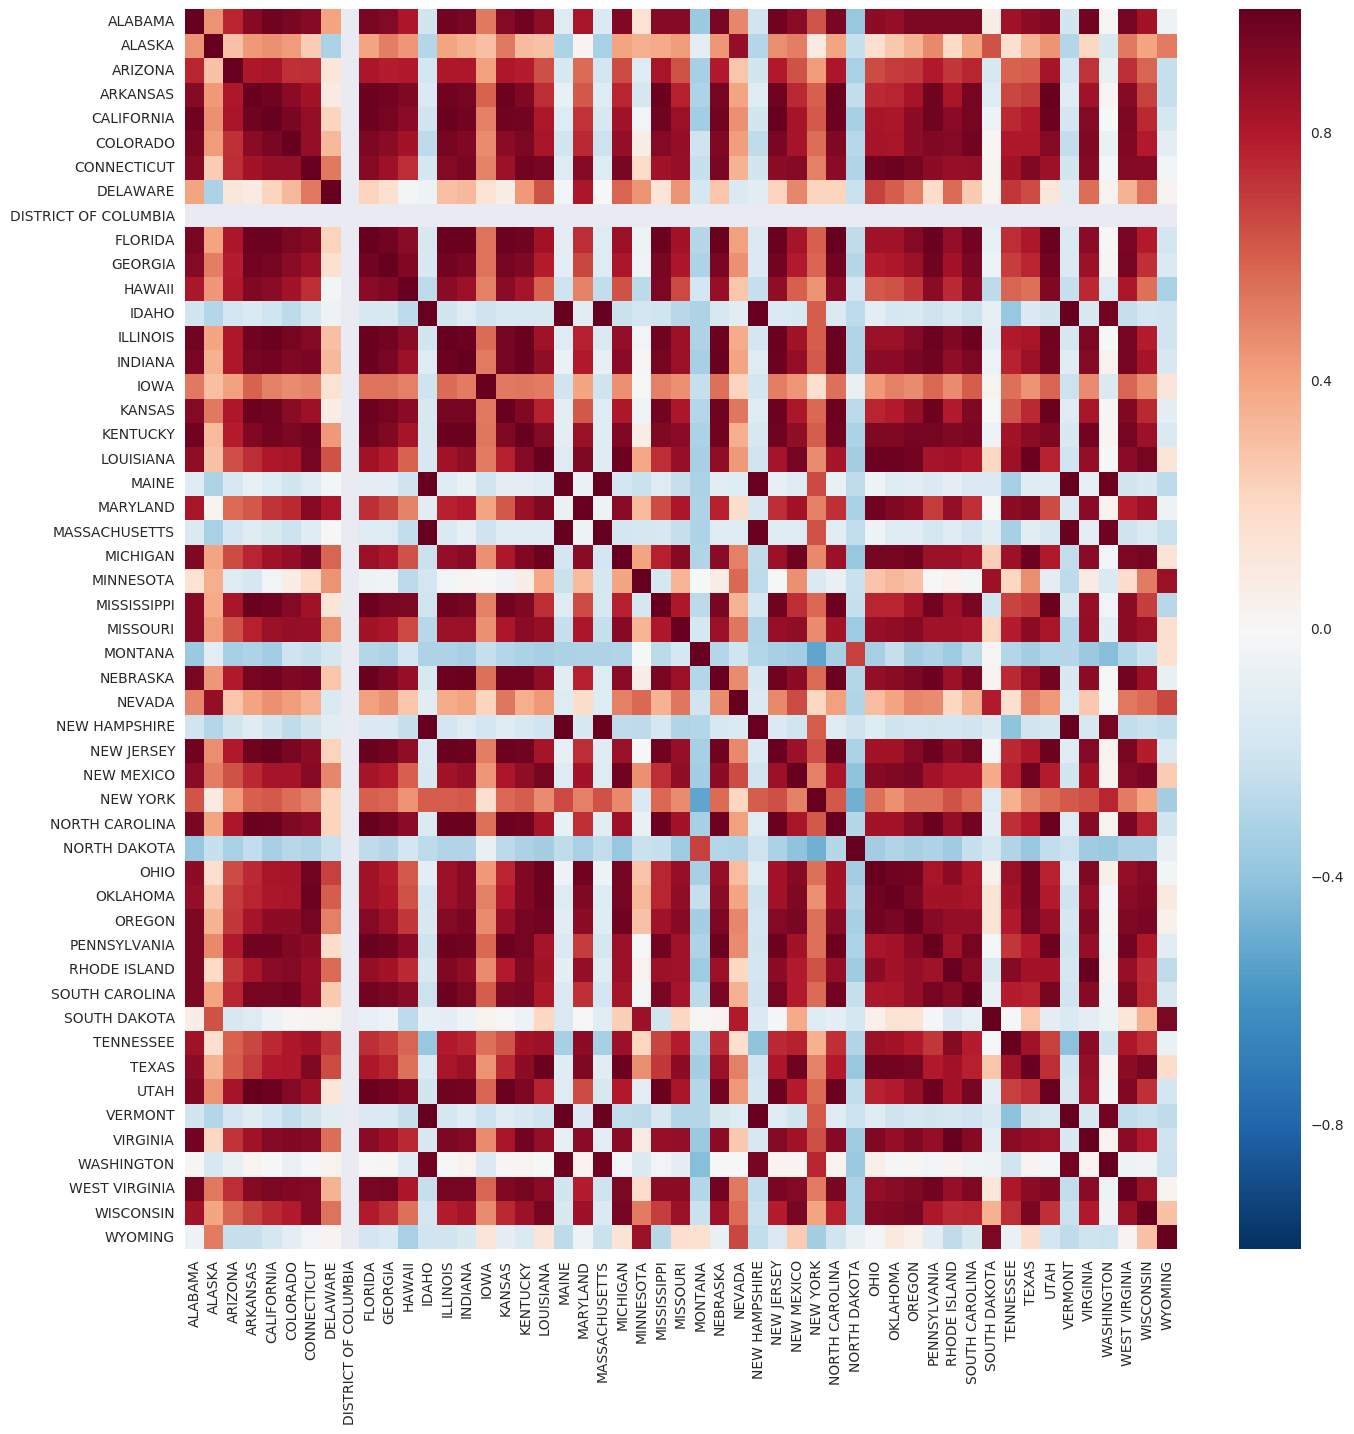

In [158]:
figure = plt.figure(figsize=(16, 16))
sns.heatmap(df_state_mentions_by_year.corr())

In [90]:
df_entities[df_entities.label == 'GPE'].entity.value_counts()

ISRAEL                   37073
AMERICA                  35176
US                       27947
RUSSIA                   17943
U.S.                     15638
GERMANY                  13205
IRAN                     12785
OBAMA                    10027
THE UNITED STATES         9169
CHINA                     8739
CALIFORNIA                7355
USA                       7214
IRAQ                      6728
FRANCE                    6425
BRITAIN                   6347
TEXAS                     5773
MEXICO                    5610
UK                        5520
CANADA                    4945
WASHINGTON                4795
FLORIDA                   4678
NEW YORK                  4396
DETROIT                   4376
ENGLAND                   4180
GREECE                    4164
HITLER                    4063
SOUTH AFRICA              3965
SWEDEN                    3900
HOLLYWOOD                 3813
JAPAN                     3808
                         ...  
WATTS COUNTY                 1
KYENGE  

In [88]:
df_entities.label.value_counts()

PERSON         665854
GPE            622591
NORP           559154
ORG            498417
LOC             71340
WORK_OF_ART     28088
EVENT           15903
FAC             15615
PRODUCT         13277
LANGUAGE         8794
LAW              6676
Name: label, dtype: int64

# Links

In [ ]:
df_links = pd.read_sql_query('')

# Slurs database?

Spoiler alert: it didn't work that well :(

In [2]:
slurs = pd.read_csv('/home/sam/data/far-right/slurs.csv', encoding='iso-8859-7')[['Slur', 'Race', 'Alt-Right']]

In [3]:
slurs_to_races = {}

for i, row in slurs.iterrows():
    slur = row['Slur'].lower()
    race = row['Race']
    slurs_to_races[slur] = race
    if slur.replace('-', '') != slur:
        slurs_to_races[slur.replace('-', '')] = race
    if slur.replace('-', ' ') != slur:
        slurs_to_races[slur.replace('-', ' ')] = race
    if slur.replace('.', '') != slur:
        slurs_to_races[slur.replace('.', '')] = race

print("Size: ", len(slurs_to_races))

Size:  1032


In [4]:
print(df_posts.shape)

df_posts.head(n=3)

(1026458, 5)


,content,author,author_title,author_location,post_date
0,\nhttp://www.reuters.com/article/oddly...2&pag...,salvete amici,Forum Member,"Christian, Free-market Libertarian",2007-05-24 15:19:00.000000
1,I suppose they wouldn't go down well with a d...,Royal Blue,Forum Member,None,2007-05-24 15:27:00.000000
2,The blacks or the rats? confused.gif \n,ArcticThunder,Account Inactive,U.S.A.,2007-05-24 15:52:00.000000


In [5]:
from nltk import word_tokenize

word_tokenize('hello-world there.')

['hello-world', 'there', '.']

In [6]:
df_posts.dropna(subset=['content'], inplace=True)

In [7]:
tokenized_words = df_posts.content.str.lower().apply(word_tokenize)

In [8]:
single_token_slurs = [x for x in slurs_to_races if ' ' not in x]
multi_token_slurs = [x for x in slurs_to_races if ' ' in x]

slurs_that_appear = []
for subpost in tokenized_words:
    subpost_slurs = []
    for slur in single_token_slurs:
        if slur in subpost:
            subpost_slurs.append(slur)
    
    slurs_that_appear.append(subpost_slurs)

In [ ]:
multitoken_slurs_that_appear = []
for post in df_posts.content.str.lower():
    subpost_slurs = []
    for slur in multi_token_slurs:
        if slur in post:
            subpost_slurs.append(slur)
            
    multitoken_slurs_that_appear.append(subpost_slurs)

In [26]:
from functools import reduce

all_post_slurs = [x + y for x, y in zip(slurs_that_appear, multitoken_slurs_that_appear)]

In [27]:
len(slurs_that_appear), len(multitoken_slurs_that_appear), len(all_post_slurs)

(1014629, 1014629, 1014629)

In [28]:
sum([len(x) != 0 for x in all_post_slurs])

132274

In [29]:
all_post_slur_races = []
for post_slurs in all_post_slurs:
    post_slur_races = []
    for slur in post_slurs:
        post_slur_races.append(slurs_to_races[slur])
    
    all_post_slur_races.append(post_slur_races)

In [32]:
df_posts['slurs'] = all_post_slurs
df_posts['slur_races'] = all_post_slur_races

In [39]:
df_posts[df_posts['slur_races'].str.len() != 0].head(20)

,content,author,author_title,author_location,post_date,slurs,slur_races
6,\r\n\t\t\t\r\n\t\t\tLouisiana has a problem wi...,mrjowee,Forum Member,None,2007-05-24 16:41:00.000000,[target],[Indians]
10,\r\n\t\t\t\r\n\t\t\t------------ --------- ---...,Bunnytoes,Open Forums - moderated,Texas,2008-11-18 13:14:00.000000,[crime],[Blacks]
13,"\r\n\t\t\t\r\n\t\t\tGood post, and a very inte...",O.W.N.,Forum Member,Cyberia,2008-11-18 14:11:00.000000,[interesting],[Jews]
19,\r\n\t\t\t\r\n\t\t\tVery interesting predictio...,Daglaff Wolfing,Forum Member,Communist Republic of Maryland,2008-11-18 16:52:00.000000,[interesting],[Jews]
20,\nAccording to the World’s No. 1 Credit Strate...,reynoldsg,"""Friend of Stormfront""Sustaining Member",None,2016-09-10 16:51:00.000000,[bubble],[Greeks]
32,\r\n\t\t\t\r\n\t\t\tI'm not a queer but he's u...,RobboPOSH,Forum Member,None,2016-11-15 18:08:00.000000,[interesting],[Jews]
41,"\r\n\t\t\t\r\n\t\t\tTalk about safe spaces, th...",Simon Legree,"""Friend of Stormfront""Sustaining Member",Yankee Land,2016-12-09 08:20:00.000000,[safe],[Blacks]
44,I had a lot of graffiti written about me in h...,ErikTheWhite,"""Friend of Stormfront""Sustaining Member",Deep South United States,2016-12-09 21:24:00.000000,[safe],[Blacks]
51,\r\n\t\t\t\r\n\t\t\tIran and Assad I'm sure wi...,Little Johnny,"""Friend of Stormfront""Sustaining Member",None,2016-12-16 18:46:00.000000,[serpent],[Whites]
53,\r\n\t\t\t\r\n\t\t\tIsrael had Hillary set the...,Little Johnny,"""Friend of Stormfront""Sustaining Member",None,2016-12-16 19:09:00.000000,[serpent],[Whites]


The slang dictionary isn't very helpful -- there are too many false positives. Out of all the first twenty hits, the only useful ones were `muzzie` and `rag-head`.

Why don't we try a different approach. First, let's look at topic models.

In [101]:
df_text = pd.read_sql_query('''
        SELECT s.*, p.thread_url as thread_url, p.author as author, a.primary_state as primary_state
            FROM (SELECT subposts.post_id, GROUP_CONCAT(subposts.content, \" \") AS text FROM subposts GROUP BY post_id) AS s
            INNER JOIN (SELECT thread_url, post_id, author, author_location FROM posts) AS p ON s.post_id = p.post_id
            LEFT JOIN (SELECT author, primary_state FROM authors) AS a ON a.author = p.author
''', 'sqlite:////home/sam/data/stormfront/stormfront.sqlite')

df_text.shape

(972846, 5)

In [ ]:
term2id = {}
for id, term in id2term.items():
    term2id[term] = id

In [ ]:
from topicmodels.text_to_term_matrix import text_to_term_matrix
import textacy
dfs = textacy.vsm.get_doc_freqs(doc_term_matrix)

In [118]:
model_nmf = textacy.tm.TopicModel('nmf', n_topics=20)

model_nmf.fit(doc_term_matrix)

In [ ]:
state_groupby = df_text.fillna('').groupby('primary_state')
states = state_groupby.primary_state.first()
texts = state_groupby.text.apply(lambda x: '\n'.join(x))

In [138]:
location_topics = []

for i, t in enumerate(texts[1:]):
    print('State: ', states[i+1])
    topics = model_nmf.transform(text_to_term_matrix(t, term2id, dfs, verbose=False))
    location_topics.append(topics)

State:  alabama
State:  alaska
State:  arizona
State:  arkansas
State:  california
State:  colorado
State:  connecticut
State:  delaware
State:  district of columbia
State:  florida
State:  georgia
State:  hawaii
State:  idaho
State:  illinois
State:  indiana
State:  iowa
State:  kansas
State:  kentucky
State:  louisiana
State:  maine
State:  maryland
State:  massachusetts
State:  michigan
State:  minnesota
State:  mississippi
State:  missouri
State:  montana
State:  nebraska
State:  nevada
State:  new hampshire
State:  new jersey
State:  new mexico
State:  new york
State:  north carolina
State:  north dakota
State:  ohio
State:  oklahoma
State:  oregon
State:  pennsylvania
State:  rhode island
State:  south carolina
State:  south dakota
State:  tennessee
State:  texas
State:  utah
State:  vermont
State:  virginia
State:  washington
State:  west virginia
State:  wisconsin
State:  wyoming


In [201]:
df_text.primary_state.value_counts()

california              18749
texas                   17829
florida                 13922
tennessee               10318
illinois                 5751
virginia                 5046
pennsylvania             5030
georgia                  4343
indiana                  4326
oregon                   4229
ohio                     4164
minnesota                4012
missouri                 3722
mississippi              3538
new york                 3513
michigan                 3512
louisiana                3450
colorado                 3119
utah                     2807
arizona                  2566
washington               2550
alabama                  2247
west virginia            2242
maryland                 2219
north carolina           2212
wisconsin                2084
iowa                     2070
oklahoma                 1896
district of columbia     1789
new jersey               1773
montana                  1748
massachusetts            1423
nevada                   1419
arkansas  

In [179]:
posters_per_state = df_text.groupby(['primary_state', 'author']).count().reset_index().primary_state.value_counts()

posters_per_state

california              351
texas                   289
florida                 259
pennsylvania            148
georgia                 130
tennessee               127
ohio                    123
michigan                103
virginia                102
illinois                 95
washington               91
arizona                  72
indiana                  71
minnesota                70
new york                 69
colorado                 66
wisconsin                62
oregon                   61
kentucky                 61
louisiana                60
alabama                  58
north carolina           58
missouri                 56
mississippi              52
maryland                 51
oklahoma                 45
arkansas                 43
massachusetts            38
idaho                    37
montana                  36
maine                    34
new jersey               32
utah                     28
south carolina           26
iowa                     26
connecticut         

In [199]:
posters_per_state.sum()

3215

In [181]:
state_topics = {}
for i, state in enumerate(states[1:]):
    if (df_text.primary_state.value_counts()[state] > 1000) and (posters_per_state[state] > 20):
        state_topics[state] = location_topics[i][0]
        
print(len(state_topics))

34


In [182]:
state_topics['california']

array([ 0.03135409,  0.01364459,  0.00567732,  0.03198987,  0.0064569 ,
        0.00321225,  0.00506008,  0.00923577,  0.03130595,  0.01481414,
        0.00435584,  0.00814414,  0.05337092,  0.00572125,  0.00545461,
        0.01081948,  0.00266125,  0.00508857,  0.00270196,  0.0003422 ])

In [208]:
sorted([[k, v[8]] for k, v in state_topics.items()], key=lambda x: x[1], reverse=True)

[['texas', 0.034124691401523778],
 ['missouri', 0.03270464604486286],
 ['california', 0.031305949889004939],
 ['iowa', 0.031284563974553148],
 ['georgia', 0.029574171475038016],
 ['pennsylvania', 0.02888078473172832],
 ['mississippi', 0.028369247313606825],
 ['florida', 0.027098742261122463],
 ['colorado', 0.026946745264674561],
 ['tennessee', 0.02621793729734808],
 ['arizona', 0.025093240895376227],
 ['arkansas', 0.0240835330783826],
 ['maryland', 0.023897438520011593],
 ['alabama', 0.023794128829926806],
 ['north carolina', 0.023690142710608576],
 ['ohio', 0.022969023137800131],
 ['illinois', 0.02262548242351034],
 ['michigan', 0.022616899556519368],
 ['washington', 0.021918931168973328],
 ['montana', 0.021466493655646911],
 ['louisiana', 0.020751763914554307],
 ['minnesota', 0.018845632819999989],
 ['kentucky', 0.018818256941928537],
 ['oregon', 0.018674368409990056],
 ['indiana', 0.018416833226977167],
 ['wisconsin', 0.017833002501642541],
 ['new jersey', 0.017008310148083683],
 ['

In [186]:
def print_state_topics(state):
    topics = state_topics[state]
    for score, terms in sorted(zip(topics, model_terms), key=lambda x: x[0], reverse=True):
        print('{}: {}'.format(score, ', '.join(terms)))

In [204]:
print_state_topics('texas')

0.04787250027612729: not, ', like, woman, people
0.03412469140152378: america, american, mexico, mexican, california
0.02009468748129885: gun, police, cop, shoot, officer
0.01814071282729425: muslim, muslims, islam, islamic, christian
0.016577733029856774: white, black, race, racist, negro
0.011733255228219455: jews, jewish, jew, holocaust, anti
0.01048900030050734: obama, president, barack, obongo, kenya
0.00995412074373897: paul, ron, ron paul, romney, candidate
0.007543860374882973: israel, israeli, palestinians, israelis, gaza
0.007373303053248722: mccain, vote, republican, party, gop
0.005686870831928929: trump, donald, cruz, donald trump, vote
0.005561226682103773: iran, iraq, iranian, nuclear, war
0.005052110485935656: school, child, kid, student, teacher
0.003607422494371585: germany, german, germans, hitler, merkel
0.003246935394267378: hillary, clinton, hillary clinton, bernie, vote
0.003184454988494421: china, chinese, japan, asian, japanese
0.0030135488611229143: russia, pu

In [185]:
model_terms = []
for topic_idx, top_terms in model_nmf.top_topic_terms(id2term, top_n=5):
    model_terms.append(top_terms)
    print(topic_idx)
    print('\n'.join(top_terms))
    print('-----\n')

0
not
'
like
woman
people
-----

1
israel
israeli
palestinians
israelis
gaza
-----

2
trump
donald
cruz
donald trump
vote
-----

3
jews
jewish
jew
holocaust
anti
-----

4
russia
putin
russian
russians
ukraine
-----

5
muslim
muslims
islam
islamic
christian
-----

6
obama
president
barack
obongo
kenya
-----

7
europe
european
eu
greece
europeans
-----

8
america
american
mexico
mexican
california
-----

9
germany
german
germans
hitler
merkel
-----

10
china
chinese
japan
asian
japanese
-----

11
mccain
vote
republican
party
gop
-----

12
paul
ron
ron paul
romney
candidate
-----

13
iran
iraq
iranian
nuclear
war
-----

14
gun
police
cop
shoot
officer
-----

15
white
black
race
racist
negro
-----

16
hillary
clinton
hillary clinton
bernie
vote
-----

17
school
child
kid
student
teacher
-----

18
france
french
paris
sarkozy
le
-----

19
sweden
swedish
swede
swedes
stockholm
-----

